<a href="https://colab.research.google.com/github/GonzaloMA-17/RL_FJLGM/blob/main/notebook_tabulares_4x4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Asignatura**: Extensiones de Machine Learning, 2024/2025

**Alumnos**:<br>
- Gonzalo Marcos Andrés (gonzalo.marcosa@um.es)
- Francisco José López Fernández (franciscojose.lopezf@um.es)

**Máster de Inteligencia Artificial**

| **Facultad de Informática** | **Universidad de Murcia** |
|-----------------------------|---------------------------|
| ![](https://www.um.es/image/layout_set_logo?img_id=175281&t=1726728636242) | ![](https://www.um.es/o/um-lr-principal-um-home-theme/images/logo-um.png) |


# **Práctica 2.  Aprendizaje en entornos complejos**

## **1. Preparación del Entorno**

In [7]:
!  git clone https://github.com/GonzaloMA-17/RL_FJLGM.git

In [8]:
%cd RL_FJLGM

[Errno 2] No such file or directory: 'RL_FJLGM'
/content/RL_FJLGM


### 1.1 Introducción.  

Este notebook se enfoca en la implementación y análisis de un agente que utiliza **Aprendizaje por Refuerzo** para resolver distintos entornos que nos ofrece `gymnasium`.  

Los entornos que vamos a utlizar son:

 - **FrozenLake (4x4)**


### 1.2. Instalación de Dependencias

Se instalan las librerías necesarias para trabajar con el entorno de simulación `gymnasium`, lo que permite crear un ambiente controlado donde el agente pueda interactuar y aprender. Este entorno simula una cuadrícula donde el agente debe navegar para alcanzar una meta, mientras se enfrenta a varios desafíos.

In [9]:
%%capture
# ! pip install 'gym[box2d]==0.20.0'
# ! pip install gymnasium[box2d]
# ! pip install "gymnasium[toy-text]
# ! pip install gymnasium
# ! pip install numpy
# ! pip install matplotlib
# ! pip install tqdm
# ! pip install torch

### 1.3 Librerías

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import random

from src_agents import *
from src_plotting import *

### 1.4 Importación de los Entornos

Se cargan dos entornos diferentes para el agente:
- **FrozenLake (4x4)** es un pequeño lago congelado en el que el agente debe navegar para llegar a su destino, evitando caer en el agua. Este entorno es especialmente útil para un aprendizaje inicial, ya que no es resbaladizo, lo que facilita la comprensión de cómo el agente interactúa con el entorno.

- **CliffWalking** el agente aquí debe caminar a lo largo de un acantilado, evitando caer en él. Este entorno introduce más complejidad, ya que las acciones del agente tienen consecuencias más dramáticas, como caer en el acantilado si no se tiene cuidado, lo que ofrece una mayor oportunidad para evaluar la capacidad del agente de aprender de los castigos y recompensas.



### 1.5 Funciones para Mostrar los Resultados
Se definen varias funciones para graficar y visualizar los resultados del entrenamiento del agente. Estas funciones permiten analizar el desempeño del agente en diferentes aspectos.
1.`plot(list_stats)`  
   - **Descripción**: Graficará la proporción de recompensas obtenidas en cada episodio del entrenamiento. Este gráfico proporciona una visualización clara del progreso del agente, mostrando cómo mejora su desempeño a medida que avanza en el proceso de aprendizaje.

2. `plot_episode_lengths(episode_lengths, window=50)`  
   - **Descripción**: Graficará la longitud de los episodios en el entrenamiento, y calculará y mostrará la tendencia de las longitudes utilizando una media móvil.

3. `plot_policy_blank(Q, env)`  
   - **Descripción**: Dibuja la política aprendida por el agente sobre un entorno vacío, representando las acciones óptimas en cada estado de la **Q-table** del agente con flechas (izquierda, abajo, derecha, arriba).

4. `plot_comparison(stats_list, labels, title="Comparación de Resultados de Entrenamiento")`  
   - **Descripción**: Compara la evolución de las recompensas obtenidas por diferentes algoritmos o agentes a lo largo del entrenamiento, permitiendo visualizar el rendimiento relativo de cada uno.

5. `plot_episode_lengths_comparison(episode_lengths_list, labels, window=50, title="Comparación de Longitudes de Episodios")`  
   - **Descripción**: Compara las longitudes de los episodios de diferentes agentes, mostrando las longitudes y las tendencias de cada uno en subgráficas separadas, con sombreado y media móvil.

Todas las funciones y clases relacionadas con la visualización de gráficos se encuentran en el archivo `src_agents/plotting.py`. Para utilizarlas, será necesario importar las librerías correspondientes desde esa ruta.

## **2. Diseño del Agente**

### 2.1 Estructura del Agente

Este es la estructura que contiene la implementación de distintos agentes, organizados en módulos específicos para facilitar su uso y mantenimiento.  

Cada agente hereda de una clase base (`agent.py`) y utiliza diferentes estrategias de aprendizaje, como **Monte Carlo**, **Q-Learning** y **SARSA**. Además, se incluyen módulos auxiliares para definir políticas de exploración y visualizar resultados.

```plaintext
|-- 📂 src_agents                  # Carpeta principal que contiene los agentes de Aprendizaje por Refuerzo
|   |-- 📄 __init__.py             # Archivo que convierte el directorio en un paquete de Python
|   |-- 📄 agent.py                # Clase base para todos los agentes
|   |-- 📄 monteCarloOnPolicy.py   # Implementación del agente Monte Carlo On-Policy
|   |-- 📄 monteCarloOffPolicy.py  # Implementación del agente Monte Carlo Off-Policy
|   |-- 📄 qLearning.py            # Implementación del agente Q-Learning
|   |-- 📄 sarsa.py                # Implementación del agente SARSA
|   |-- 📄 politicas.py            # Definición de políticas de exploración como epsilon-greedy y softmax
|   |-- 📄 plotting.py             # Funciones de visualización de datos y gráficos


El diseño del agente consta de dos partes.  

- Las políticas (toma de decisiones) que realiza.
- El algoritmo con el que aprende.

### 2.2 Políticas del Agente

- **Epsilon-soft**: Se define una política donde todas las acciones tienen una probabilidad de ser elegida.
   
- **Política epsilon-greedy**: basada en la política epsilon-soft. De esta forma el agente tiene una pequeña probabilidad de explorar (tomar una acción aleatoria) y una mayor probabilidad de explotar (tomar la acción que considera mejor). Esto permite equilibrar la exploración y la explotación.  

- **Política greedy**: Es la usada una vez que "ha aprendido".  

### 2.3 Algoritmos


- **Tabulares**  
  - Monte Carlo On Policy  
  - Monte Carlo Off Policy  
  - SARSA
  - Q - Learning

- **Control con Aproximaciones**
  - SARSA semigradiente
  - Deep Q - Learning


## **3. Experimentación - Frozen Lake**

FrozenLake es un entorno de Aprendizaje por Refuerzo incluido en Gymnasium, en el que un agente debe aprender a desplazarse sobre una superficie helada para llegar a un objetivo sin caer en agujeros. Se representa como una cuadrícula donde cada celda puede ser suelo firme, un agujero o la meta.

El agente puede moverse en cuatro direcciones: izquierda, derecha, arriba y abajo. En la versión estándar del entorno, el hielo introduce un factor de aleatoriedad en los movimientos, lo que significa que el agente no siempre se desplaza en la dirección elegida. Sin embargo, en este caso **configuraremos el entorno sin deslizamiento**, lo que significa que el agente se moverá exactamente en la dirección que elija sin desviaciones aleatorias. Esto hace que el problema sea más determinista y permite un aprendizaje más directo de las estrategias óptimas.

El objetivo del agente es llegar a la casilla de meta desde la posición inicial sin caer en un agujero. Se utiliza un sistema de recompensas en el que el agente recibe una recompensa de 1 cuando alcanza la meta y 0 en cualquier otro caso. Al eliminar el deslizamiento, el agente puede aprender una política óptima de manera más eficiente, ya que sus acciones tienen consecuencias predecibles.

### 3.1 Monte Carlo On-Policy

Monte Carlo (MC) es un método de aprendizaje por refuerzo basado en la simulación de episodios completos para actualizar la función de valor de estado-acción $Q(s,a)$. En el enfoque **On-Policy**, seguimos una política de exploración ($\epsilon$-greedy) y actualizamos $Q$ en función de las recompensas obtenidas.

**Características clave del método Monte Carlo On-Policy**:

- Aprende a partir de episodios completos (del estado inicial al terminal).  
- La actualización de $Q(s,a)$ se realiza utilizando el retorno $G$, que es la recompensa acumulada futura descontada:

  $$
  G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots + \gamma^{T-t-1} R_T
  $$

- Utiliza un promedio incremental para actualizar $Q$, en lugar de una tasa de aprendizaje fija:

  $$
  Q(s,a) \leftarrow Q(s,a) + \frac{1}{N(s,a)} (G - Q(s,a))
  $$

  donde $N(s,a)$ es el número de veces que se ha visitado el par $(s,a)$.  
- Sigue una estrategia **On-Policy**, lo que significa que la misma política utilizada para generar episodios también se usa para mejorar $Q$.  

**Ecuación de actualización de $Q(s,a)$:**
$$
Q(s,a) \leftarrow Q(s,a) + \alpha \cdot (G - Q(s,a))
$$

donde:  
- $G$ es el retorno acumulado desde el estado $s$ y la acción $a$.  
- $\alpha$ es un promedio incremental basado en el número de visitas:  

  $$
  \alpha = \frac{1}{N(s,a)}
  $$

#### 3.1.1 Mapa 4x4

**Implementación**  

En primer lugar, establecemos una semilla para la reproducibilidad del problema

In [11]:
seed_value = 1995
np.random.seed(seed_value)  # Establecer semilla de numpy
random.seed(seed_value)  # Establecer semilla de random

Se crea un entorno de FrozenLake 4x4 sin deslizamiento (``'is_slippery=False'``), lo que hace que el movimiento del agente sea determinista.

In [12]:
# Crear el entorno
env_mc_on_policy = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4", render_mode="ansi")

**Creación del agente Monte Carlo On-Policy**

Ahora tenemos que instanciar el agente ``MonteCarloOnPolicy``, con las siguientes característica:

- ``epsilon=0.4``: Inicialmente, el agente explorará con una probabilidad del 40%.  

- ``gamma=1.0``: Se utiliza un factor de descuento completo, lo que significa que se consideran todas las recompensas futuras sin atenuación.

- ``decay=True``: Permite que epsilon disminuya con el tiempo, lo que ayuda al agente a explotar más a medida que aprende.

- ``num_episodios=50000``: El agente se entrena durante 50,000 episodios para garantizar un aprendizaje suficiente.


In [13]:
# Instanciamos el agente
agente_mc_on_policy = MonteCarloOnPolicy(env_mc_on_policy, epsilon=0.4, gamma=1.0, decay=True, num_episodios=50000)

Luego, se llama al método ``entrenar()``, que devuelve los siguientes resultados:  

- ``Q_mc_on_policy``: La Q-table entrenada.  

- ``stats_mc_on_policy``: Una lista con la recompensa media acumulada por episodio.  

- ``episode_lengths_mc_on_policy``: Una lista con la longitud de cada episodio.  

In [14]:
Q_mc_on_policy, stats_mc_on_policy, episode_lengths_mc_on_policy = agente_mc_on_policy.entrenar()

Entrenando: 100%|█████████████████████████████████████| 50000/50000 [00:34<00:00, 1428.97episodio/s]


**Evaluación de la política aprendida**  
Una vez entrenado el agente con el algoritmo Monte Carlo On-Policy, **es fundamental evaluar la política aprendida para comprobar su eficacia en la resolución del entorno**. Para ello, se extrae la política óptima a partir de la Q-table obtenida durante el entrenamiento.

- ``pi_star_from_Q()`` extrae la política óptima a partir de la Q-table entrenada.

- ``actions_mc_on_policy`` contiene la secuencia de acciones óptimas para resolver FrozenLake.

- La política óptima representa la mejor estrategia aprendida por el agente para llegar a la meta.

In [15]:
pi_star_mc_on_policy, actions_mc_on_policy = pi_star_from_Q(env_mc_on_policy, Q_mc_on_policy)

**Conclusión**

Para evaluar de manera integral el desempeño del agente entrenado, es útil visualizar distintos aspectos clave de su aprendizaje.  

En esta sección, se presentará una función que genera una figura con tres gráficos principales:

- **Proporción de recompensas por episodio**, lo que permite observar cómo evoluciona la capacidad del agente para alcanzar la meta a lo largo del entrenamiento.

- **Longitud de los episodios**, incluyendo una media móvil para analizar la estabilidad del aprendizaje y la eficiencia del agente en la resolución del entorno.

- **Política aprendida**, representada gráficamente en el entorno de FrozenLake, donde se muestra la mejor acción aprendida mediante flechas direccionales.  

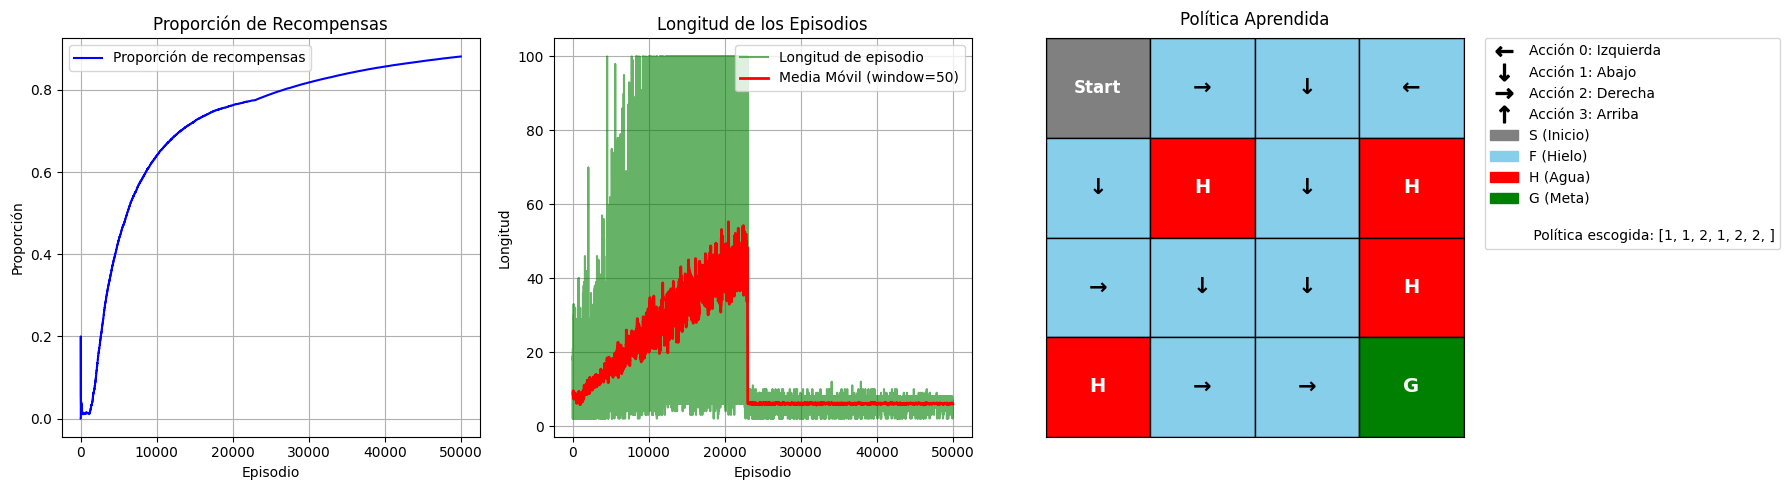

In [16]:
plot_all_three(
    list_stats=stats_mc_on_policy,
    episode_lengths=episode_lengths_mc_on_policy,
    Q=Q_mc_on_policy,
    env=env_mc_on_policy,
    actions=actions_mc_on_policy,
    window=50  # O el valor que quieras
)


En la gráfica de la **izquierda**, se muestra la **proporción de recompensas** obtenidas por episodio. Se observa una tendencia ascendente, lo que indica que el agente **mejora progresivamente su rendimiento**. Este resultado sugiere que la política aprendida es cada vez más efectiva para maximizar las recompensas en el entorno.

En la gráfica **central**, se representa la **longitud de los episodios**. Al inicio del entrenamiento, la longitud de los episodios es muy variable y, en muchos casos, elevada (se toman más pasos antes de terminar). Sin embargo, con el tiempo se aprecia una **disminución y estabilización** de la duración de los episodios, reforzada por la línea roja de media móvil. Esto evidencia que el agente **aprende a resolver el entorno de forma más eficiente**, reduciendo la cantidad de pasos necesarios para alcanzar un estado terminal (ya sea por caer en un agujero o llegar a la meta).

Por último, en la **derecha** se muestra la **política aprendida** en el tablero de *Frozen Lake*. Cada celda de tipo “F” (hielo seguro) contiene una flecha que indica la **acción óptima** aprendida por el agente. Las celdas “H” (hoyo/agua) y “G” (meta) se marcan en rojo y verde, respectivamente, para señalar que son estados terminales. Este diagrama revela que la política aprendida evita las celdas “H” siempre que sea posible y traza un camino consistente hacia la meta “G”.  

En conjunto, los tres gráficos confirman que:
1. El **rendimiento** del agente (proporción de recompensas) **aumenta** progresivamente.  
2. La **longitud de los episodios** **disminuye**, reflejando una **mayor eficiencia** en la toma de decisiones.  
3. La **política final** conduce al agente a **evitar los hoyos** y **alcanzar la meta** de manera consistente.  

Estos resultados evidencian que el agente ha **convergido** a una solución razonable para la tarea de *FrozenLake*, aprendiendo a **maximizar recompensas** y **minimizar pasos** necesarios para completar cada episodio.

### 3.2 Monte Carlo Off-Policy

Monte Carlo (MC) es un método de aprendizaje por refuerzo basado en la simulación de episodios completos para actualizar la función de valor de estado-acción $Q(s,a)$. En la variante **Off-Policy**, la política que se utiliza para generar los episodios (política de comportamiento $b$) puede ser distinta de la política objetivo $\pi$ que deseamos aprender. Para corregir el sesgo introducido por el uso de diferentes políticas, se emplea **Weighted Importance Sampling (WIS)**.

Características clave del método Monte Carlo Off-Policy:

- Uso de dos políticas:

    - **Política de comportamiento ($b$)**: En este caso, es $\epsilon$-greedy respecto a la Q-table.  
    - **Política objetivo ($\pi$)**: Determinista (greedy) en base a la Q-table.  

- Simulación de episodios completos:

Al igual que en Monte Carlo On-Policy, el agente aprende al terminar cada episodio. Sin embargo, las trayectorias se obtienen usando la política de comportamiento $b$.

- Corrección con Weighted Importance Sampling:

Cada transición se pondera con un factor de importancia $W$ que mide la razón entre la probabilidad de la acción bajo la política objetivo $\pi$ y la probabilidad de la acción bajo la política de comportamiento $b$. Formalmente:

$$
W \leftarrow W \times \frac{\pi(a_t | s_t)}{b(a_t | s_t)}
$$

Si $\pi(a_t | s_t) = 0$ (es decir, la política objetivo nunca tomaría esa acción), se corta la retropropagación para evitar actualizaciones no representativas.

- Actualización de $Q(s,a)$:

Se realiza de manera incremental, similar al caso On-Policy, pero multiplicando por el factor $W$. Por ejemplo:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha W (G - Q(s,a))
$$

donde $\alpha = \frac{1}{N(s,a)}$ es un promedio incremental basado en el número de visitas al par $(s,a)$.


#### 3.2.1 Mapa 4x4

**Implementación**

En primer lugar, se establece una semilla para la reproducibilidad y se crea un entorno FrozenLake 4x4 sin deslizamiento (``is_slippery=False``).

In [17]:
seed_value = 1995
np.random.seed(seed_value)  # Establecer semilla de numpy
random.seed(seed_value)  # Establecer semilla de random

# Creación del entorno
env_mc_off_policy4x4 = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4", render_mode="ansi")

A continuación, se instancia el agente **MonteCarloOffPolicy**, indicando:

- ``epsilon=0.4``: exploración inicial para la política de comportamiento.  

- ``gamma=1.0``: se consideran todas las recompensas futuras sin descuento.  

- ``decay=True``: para reducir 𝜖 gradualmente.  

- ``num_episodios=50000``: un número grande de episodios para asegurar la convergencia.  

In [18]:
agente_mc_off_policy4x4 = MonteCarloOffPolicy(env_mc_off_policy4x4, decay=True, num_episodios=50000)

El método `entrenar()` genera episodios siguiendo la política de comportamiento $\epsilon$-greedy.  

Al terminar cada episodio, se calcula el retorno $G$ y se actualiza $Q$ de atrás hacia adelante.  

Cada par $(s,a)$ se corrige con **Weighted Importance Sampling (Weighted IS)**, de modo que las trayectorias sean evaluadas como si provinieran de la política objetivo $\pi$.


In [19]:
# Entrenar el agente
Q_mc_off_policy4x4, stats_mc_off_policy4x4, episode_lengths_mc_off_policy4x4 = agente_mc_off_policy4x4.entrenar()

Entrenando Off-Policy (WIS):  10%|██▏                   | 5102/50000 [00:04<01:02, 721.37episodio/s]

Episodio 5000, recompensa promedio: 0.13, epsilon: 0.20


Entrenando Off-Policy (WIS):  20%|████▎                | 10163/50000 [00:10<00:44, 889.78episodio/s]

Episodio 10000, recompensa promedio: 0.39, epsilon: 0.10


Entrenando Off-Policy (WIS):  30%|██████▎              | 15096/50000 [00:18<00:49, 711.30episodio/s]

Episodio 15000, recompensa promedio: 0.55, epsilon: 0.07


Entrenando Off-Policy (WIS):  40%|████████▍            | 20065/50000 [00:27<00:57, 518.01episodio/s]

Episodio 20000, recompensa promedio: 0.63, epsilon: 0.05


Entrenando Off-Policy (WIS):  50%|██████████▌          | 25069/50000 [00:38<00:52, 476.58episodio/s]

Episodio 25000, recompensa promedio: 0.67, epsilon: 0.04


Entrenando Off-Policy (WIS):  60%|████████████▌        | 30058/50000 [00:50<00:48, 412.49episodio/s]

Episodio 30000, recompensa promedio: 0.69, epsilon: 0.03


Entrenando Off-Policy (WIS):  70%|██████████████      | 35223/50000 [00:59<00:10, 1459.51episodio/s]

Episodio 35000, recompensa promedio: 0.71, epsilon: 0.03


Entrenando Off-Policy (WIS):  81%|████████████████▏   | 40330/50000 [01:01<00:04, 2078.81episodio/s]

Episodio 40000, recompensa promedio: 0.74, epsilon: 0.02


Entrenando Off-Policy (WIS):  91%|██████████████████▏ | 45399/50000 [01:04<00:02, 2037.02episodio/s]

Episodio 45000, recompensa promedio: 0.76, epsilon: 0.02


Entrenando Off-Policy (WIS): 100%|█████████████████████| 50000/50000 [01:06<00:00, 749.83episodio/s]


**Evaluación de la política aprendida**

Una vez entrenado el agente, se evalúa la política objetivo con `pi_star_from_Q`. Esta función recorre el entorno seleccionando en cada estado la acción greedy según $Q$.  

Devuelve:  

- `pi_mc_off_policy`: Matriz que indica la acción óptima en cada estado.  
- `actions_mc_off_policy`: Cadena con la secuencia de acciones (0= izquierda, 1= abajo, 2= derecha, 3= arriba) que lleva al agente desde la posición inicial hasta la meta (o hasta caer en un agujero).


In [20]:
pi_mc_off_policy4x4, actions_mc_off_policy4x4 = pi_star_from_Q(env_mc_off_policy4x4, Q_mc_off_policy4x4)

**Conclusión**

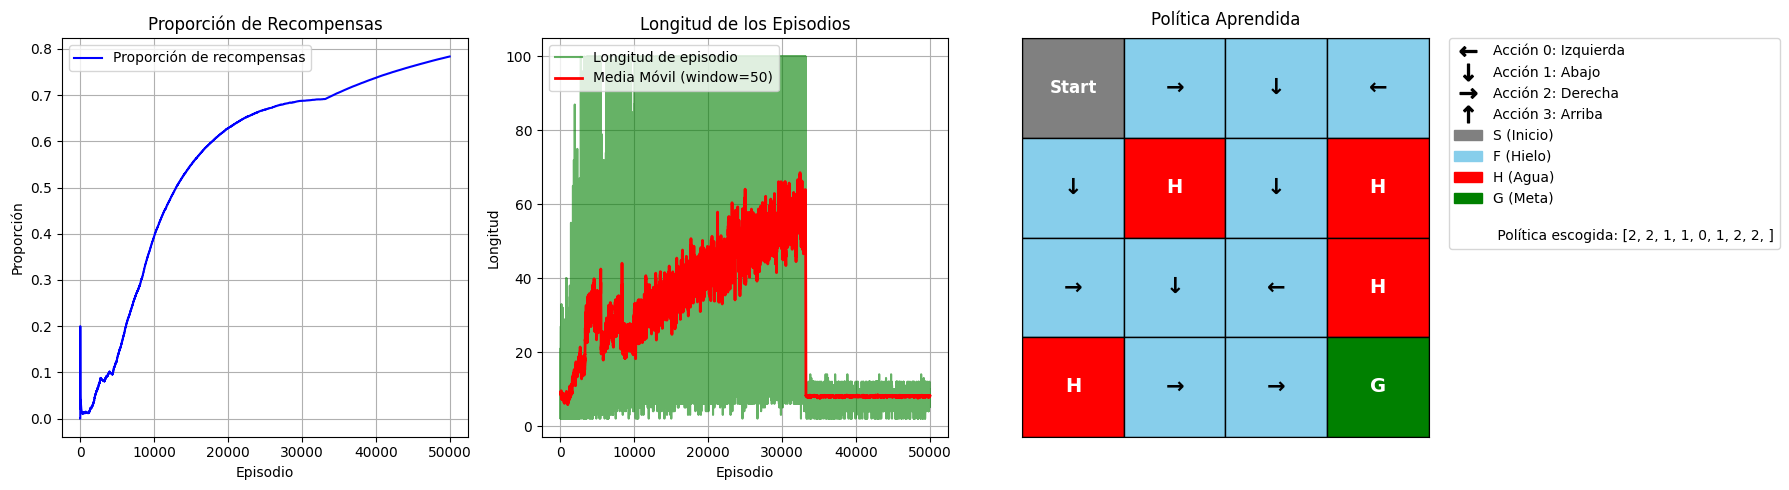

In [21]:
plot_all_three(
    list_stats = stats_mc_off_policy4x4,
    episode_lengths = episode_lengths_mc_off_policy4x4,
    Q = Q_mc_off_policy4x4,
    env = env_mc_off_policy4x4,
    actions = actions_mc_off_policy4x4,
    window=50
)

- En la **gráfica de la izquierda**, se observa la **proporción de recompensas** obtenidas por episodio, mostrando un incremento progresivo a lo largo del entrenamiento. Este comportamiento indica que el agente **aprende a maximizar sus recompensas** de forma cada vez más consistente, lo que sugiere una **mejora continua** en su desempeño.

- En la **gráfica central**, se presenta la **longitud de los episodios**. Inicialmente, la duración de los episodios exhibe una gran variabilidad y, con frecuencia, es elevada (el agente necesita más pasos para concluir). Sin embargo, con el avance del entrenamiento se aprecia una **reducción y estabilización** de la longitud de los episodios, confirmada por la curva roja de media móvil. Este resultado refleja que el agente **gana eficiencia** al resolver el entorno, tardando cada vez menos pasos en alcanzar un estado terminal.

- En la **gráfica de la derecha**, se muestra la **política aprendida** sobre el tablero de *FrozenLake*. Cada casilla de tipo “F” (hielo seguro) incluye una flecha que señala la **acción óptima** seleccionada por el agente. Las celdas “H” (hoyo/agua) y “G” (meta) se señalan en rojo y verde, respectivamente, para resaltar que son estados terminales. El diagrama deja ver que el agente **evita sistemáticamente** los hoyos y traza un **camino efectivo** hacia la meta, cumpliendo así su objetivo de maximizar recompensas y minimizar riesgos.

En conjunto, estos tres gráficos evidencian que:
1. El agente **incrementa** su rendimiento (proporción de recompensas) de manera sostenida.  
2. La **longitud de los episodios** se **reduce** con el entrenamiento, denotando un **aumento en la eficiencia** de sus decisiones.  
3. La **política final** logra **esquivar** los hoyos y **llegar** a la meta de manera consistente.

En conclusión, el agente ha **conseguido** una estrategia sólida para afrontar el desafío de *FrozenLake*, **maximizando** las recompensas obtenidas y **minimizando** la cantidad de pasos necesarios para completar cada episodio.

### 3.3 SARSA

SARSA (State-Action-Reward-State-Action) se caracteriza por actualizar la función de valor de estado-acción $Q(s,a)$ en cada paso del episodio, utilizando la siguiente ecuación base:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \left[ R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s,a) \right]
$$

donde:

- $s$ y $a$ son el estado y la acción actuales,
- $R_{t+1}$ es la recompensa obtenida tras ejecutar $a$,
- $s_{t+1}$ y $a_{t+1}$ son el estado y la acción siguientes,
- $\alpha$ es la tasa de aprendizaje,
- $\gamma$ es el factor de descuento.

A diferencia de **Q-Learning**, que usa la mejor acción posible en el estado siguiente ($\max_{a'} Q(s_{t+1}, a')$) para actualizar $Q$, **SARSA** emplea la acción real que se va a tomar ($a_{t+1}$), siguiendo la misma política que genera los datos.

**Características Clave de SARSA**

- On-Policy:
La misma política ($\epsilon$-greedy) se usa para explorar (generar la acción $a_{t+1}$) y para actualizar la Q-table.

- Actualización Paso a Paso (TD(0)):
El agente no espera a que finalice el episodio; tras cada transición $(s,a,r,s')$, se selecciona $a'$ y se actualiza $Q(s,a)$ en función de $Q(s',a')$.

- Equilibrio entre Exploración y Explotación:
Con $\epsilon$-greedy, el agente explora con probabilidad $\epsilon$ y explota (selecciona la mejor acción) con probabilidad $1-\epsilon$.

#### 3.3.1 Mapa 4x4

**Implementación**  

En el archivo ``sarsa.py``, hemos implementado la clase SARSA que extiende de Agente.

- `exploration_rate` ($\epsilon$):
Controla la probabilidad de explorar.  
Con valor 0.9, significa que, inicialmente, el agente elegirá una acción aleatoria el 90% de las veces y la mejor acción el 10% de las veces.  
A medida que el agente aprende, este valor puede decaer para favorecer la explotación de lo aprendido.

- `discount_rate` ($\gamma$):
Es el factor de descuento para las recompensas futuras.  
Un valor cercano a 1.0 indica que el agente tiene en cuenta casi en su totalidad las recompensas lejanas en el tiempo.

- `learning_rate` ($\alpha$):
Determina cuánto se ajusta la Q-table en cada actualización.  
Un valor de 0.1 significa que, en cada paso, el agente corrige su estimación de $Q(s,a)$ en un 10% de la diferencia entre la estimación actual y la nueva información recibida.

- `exploration_decay_rate`:
Es la tasa de decaimiento de la probabilidad de exploración ($\epsilon$).  
Cuanto mayor sea este valor, más rápidamente se reducirá la probabilidad de que el agente tome acciones aleatorias, enfocándose cada vez más en la acción óptima según la Q-table.

- `min_exploration_rate`:
Es el límite inferior de la tasa de exploración.  
Evita que $\epsilon$ se vuelva tan pequeño que el agente deje de explorar por completo. Con 0.01, se garantiza al menos un 1% de probabilidad de explorar incluso en etapas avanzadas del entrenamiento.

- `seed`:
Semilla para la reproducibilidad de resultados.  
Asegura que, usando el mismo valor, se obtenga el mismo comportamiento aleatorio (mismas acciones exploratorias) en sucesivas ejecuciones, facilitando la comparación de experimentos.


In [22]:
# Establecer semilla para reproducibilidad
seed_value = 1995
np.random.seed(seed_value)
random.seed(seed_value)

# Definir los hiperparámetros
hiperparametros_sarsa = {
    "exploration_rate": 0.9,
    "discount_rate": 0.99,
    "learning_rate": 0.1,
    "exploration_decay_rate": 0.001,
    "min_exploration_rate": 0.01,
    "seed": 1995
}

Después, se crea un entorno FrozenLake 4x4 sin deslizamiento (``is_slippery=False``) se le pasan estos parametros e pasa todo esto al constructor de Agente para configurar la semilla, la Q-table y los demás elementos para su correcto funcionamiento.

In [23]:
# Creación del entorno
env_sarsa = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4", render_mode="ansi")

# Crear el agente SARSA
agente_sarsa = SARSA(env_sarsa, hiperparametros_sarsa)

Conitnuamos con el entrenamiento.

In [24]:
Q_sarsa, stats_sarsa, episode_lengths_sarsa = agente_sarsa.entrenar(num_episodios=50000)

Entrenando: 100%|█████████████████████████████████████| 50000/50000 [00:16<00:00, 2993.53episodio/s]


**Evaluación de la política aprendida**

Una vez entrenado el agente, se evalúa la política objetivo con `pi_star_from_sarsa`. Esta función recorre el entorno seleccionando en cada estado la acción greedy según $Q$.  

Devuelve:  

- `pi_star_sarsa`: Matriz que indica la acción óptima en cada estado.  
- `actions_sarsa`: Cadena con la secuencia de acciones (0= izquierda, 1= abajo, 2= derecha, 3= arriba) que lleva al agente desde la posición inicial hasta la meta (o hasta caer en un agujero).


In [25]:
pi_star_sarsa, actions_sarsa = pi_star_from_Q(env_sarsa, Q_sarsa)

**Conclusión**

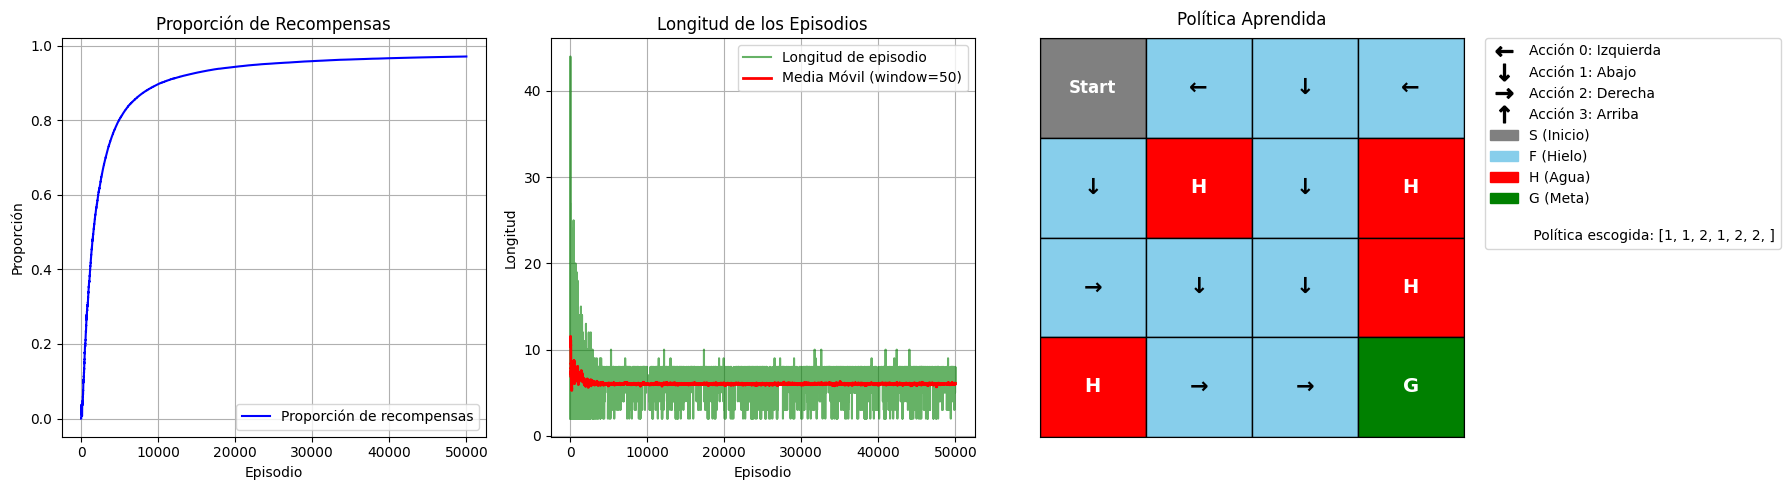

In [26]:
plot_all_three(
    list_stats=stats_sarsa,
    episode_lengths=episode_lengths_sarsa,
    Q=Q_sarsa,
    env=env_sarsa,
    actions=actions_sarsa,
    window=50  # O el valor que quieras
)

- En la **gráfica de la izquierda**, se aprecia la **proporción de recompensas** obtenidas por episodio, con una **rápida convergencia** hacia valores cercanos al máximo. Esto indica que el agente **aprende de forma acelerada** a obtener recompensas y a resolver el entorno de manera efectiva.

- En la **gráfica central**, se muestra la **longitud de los episodios**, junto con una **media móvil** para facilitar la observación de la tendencia. Se ve que, al inicio, la duración de los episodios es **altamente variable** y, con frecuencia, elevada. Sin embargo, conforme avanza el entrenamiento, la longitud se **reduce** de forma considerable y se **estabiliza** en valores bajos. Esto evidencia que el agente **descubre** un camino más eficiente para llegar a la meta, necesitando menos pasos para completar cada episodio.

- En la **gráfica de la derecha**, se ilustra la **política aprendida** en el tablero de *FrozenLake*. Las celdas “F” (hielo seguro) contienen **flechas** que indican la **acción óptima**; las celdas “H” (hoyo/agua) y “G” (meta) se colorean en rojo y verde, respectivamente, para recalcar que son estados terminales. El diagrama revela que la política **evita** los hoyos y traza un **camino eficaz** hacia la meta.  

En conjunto, los tres gráficos muestran que:
1. El **rendimiento** (proporción de recompensas) **alcanza** rápidamente niveles cercanos al óptimo.  
2. La **longitud de los episodios** se **reduce** de manera sustancial, demostrando **mayor eficiencia** en la resolución del entorno.  
3. La **política final** permite al agente **evitar** sistemáticamente los hoyos y **llegar** a la meta con un **número mínimo de pasos**.  

Estos resultados evidencian que el agente ha logrado **aprender** una estrategia sólida y **convergido** satisfactoriamente al reto de *FrozenLake*.

### 3.4 Q_Learning

Q-Learning es un método de aprendizaje temporal-diferido (TD) que permite al agente aprender la función de valor de estado-acción $Q(s,a)$ sin requerir una política específica para generar los datos (por ello, se considera un método Off-Policy). A diferencia de SARSA, donde se utiliza la acción efectivamente seleccionada ($a_{t+1}$), en Q-Learning se actualiza $Q(s,a)$ basándose en la mejor acción posible en el estado siguiente:

$$
\max_{a'} Q(s', a')
$$

independientemente de la acción que realmente se elija para la exploración.

- Ecuación de Actualización de Q-Learning

En cada paso, tras observar la transición $(s,a,r,s')$, se aplica:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right]
$$

donde:

- $s$, $a$ son el estado y la acción antes de la transición.
- $r$ es la recompensa inmediata.
- $s'$ es el nuevo estado tras ejecutar la acción $a$.
- $\max_{a'} Q(s', a')$ denota el mejor valor de acción en el estado siguiente (vista Off-Policy).
- $\alpha$ es la tasa de aprendizaje.
- $\gamma$ es el factor de descuento.

Con este enfoque, la actualización de $Q$ no depende de la acción que se tome realmente en $s'$ para explorar, sino que asume que se elegirá la acción óptima. Por ello, Q-Learning converge a la política óptima si se exploran suficientemente todos los estados y acciones (por ejemplo, usando $\epsilon$-greedy con decaimiento de $\epsilon$).


#### 3.4.1 Mapa 4x4

**Implementación**

Comenzamos seleccionando una semilla para la repetibilidad del ejercicio y seleccionamos los hiperparámetros con los que vamos a trabajar.

- **``learning_rate ($\alpha$)``**

    Controla la velocidad a la que se actualizan los valores $Q(s,a)$.
    - Un valor alto ($\alpha \approx 1$) hace que el agente se adapte muy rápido a la nueva información, pero puede ser inestable.
    - Un valor bajo ($\alpha \approx 0$) hace que el agente aprenda de forma más lenta y conservadora.

- **``discount_rate ($\gamma$)``**

    Factor de descuento que pondera la importancia de las recompensas futuras.
    - Un valor cercano a 1 ($\gamma \approx 1$) indica que el agente considera fuertemente las recompensas lejanas.
    - Un valor cercano a 0 ($\gamma \approx 0$) hace que el agente se centre casi exclusivamente en la recompensa inmediata.

- **``exploration_rate ($\epsilon$)``**

    Probabilidad de que el agente elija una acción aleatoria (exploración) en lugar de la acción con mejor valor $Q$ (explotación).
    - Un valor alto ($\epsilon \approx 1$) implica mucha exploración; un valor bajo ($\epsilon \approx 0$) favorece la explotación.

- **``exploration_decay_rate``**

    Tasa a la que $\epsilon$ disminuye a lo largo de los episodios.
    - Cuanto mayor sea, más rápido se reduce la exploración y se potencia la explotación de la política aprendida.
    - 'min_exploration_rate'

- **``Límite inferior para $\epsilon$.``**
    - Garantiza que el agente mantenga cierta probabilidad de explorar incluso en fases avanzadas del entrenamiento, evitando que $\epsilon$ llegue a 0.

- **``seed``**
    - Asegura que los elementos aleatorios (acciones, inicializaciones) puedan replicarse en sucesivas ejecuciones, permitiendo comparar resultados de forma consistente.


In [27]:
# Establecer semilla para reproducibilidad
seed_value = 1995
np.random.seed(seed_value)
random.seed(seed_value)

# Parámetros para el agente
hiperparametros_ql = {
    'learning_rate': 0.1,
    'discount_rate': 0.99,
    'exploration_rate': 1.0,
    'exploration_decay_rate': 0.001,
    'min_exploration_rate': 0.01,
    'seed': seed_value  # Pasamos la semilla al agente
}

Luego, creamos el entorno, realizamos la creación del agente y comenzamos con el entrenamiento

In [28]:
env_ql = gym.make("FrozenLake-v1", is_slippery=False, map_name="4x4", render_mode="ansi")
env_ql.reset(seed=seed_value)
agente_ql = QLearning(env_ql, hiperparametros_ql)
Q_ql, stats_ql, episode_lengths_ql = agente_ql.entrenar(num_episodios=50000)

Entrenando: 100%|█████████████████████████████████████| 50000/50000 [00:14<00:00, 3440.50episodio/s]


**Evaluación de la política aprendida**

Una vez entrenado el agente, se evalúa la política objetivo con `pi_star_from_Q`. Esta función recorre el entorno seleccionando en cada estado la acción greedy según $Q$.  

Devuelve:  

- `pi_ql`: Matriz que indica la acción óptima en cada estado.  
- `actions_ql`: Cadena con la secuencia de acciones (0= izquierda, 1= abajo, 2= derecha, 3= arriba) que lleva al agente desde la posición inicial hasta la meta (o hasta caer en un agujero).


In [29]:

pi_star_ql, actions_ql = pi_star_from_Q(env_ql, Q_ql)


**Conclusión**

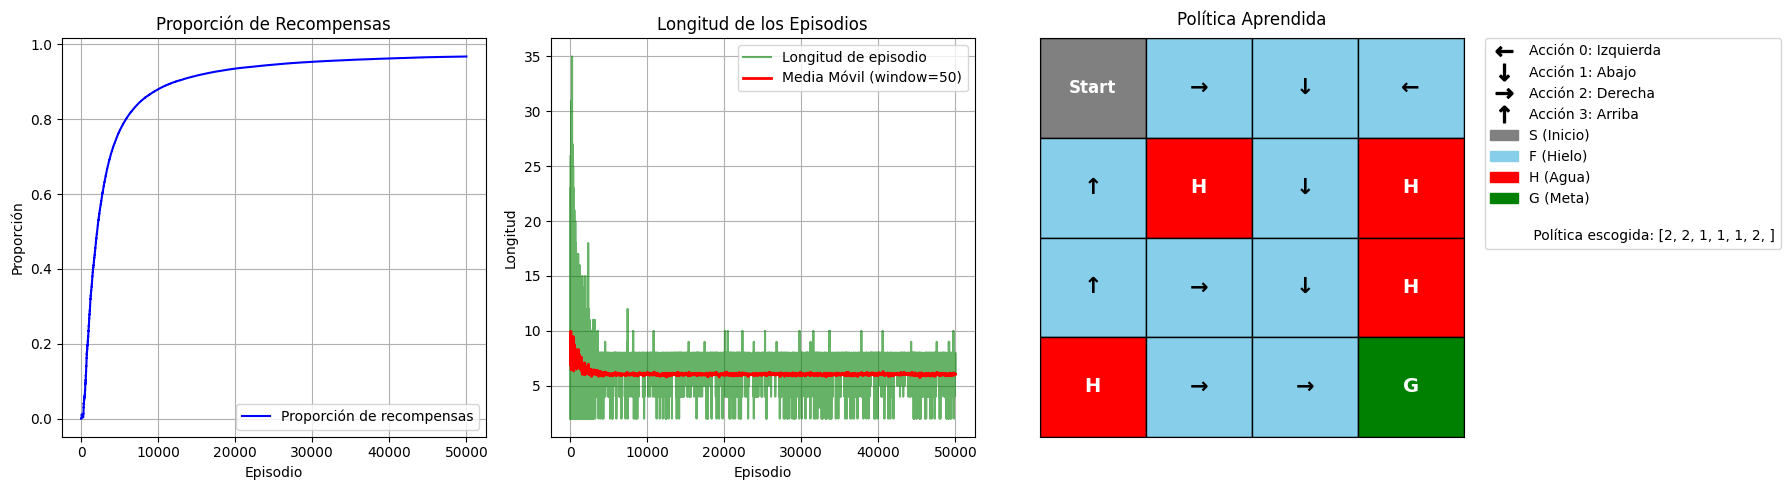

In [30]:
plot_all_three(
    list_stats=stats_ql,
    episode_lengths=episode_lengths_ql,
    Q=Q_ql,
    env=env_ql,
    actions=actions_ql,
    window=50  # O el valor que quieras
)

- En la **gráfica de la izquierda**, la **proporción de recompensas** por episodio crece de manera **rápida** y se acerca a un valor muy alto, lo que indica que el agente **aprende con eficacia** a maximizar sus recompensas. Esta tendencia ascendente sugiere que la política aprendida es cada vez más **efectiva** para alcanzar la meta y evitar los agujeros.

- En la **gráfica central**, se muestra la **longitud de los episodios**, junto con una **media móvil** que suaviza la curva. Se ve que, tras un periodo inicial de alta variabilidad, la longitud de los episodios **disminuye** de manera notable y se **estabiliza**. Este resultado confirma que el agente **descubre** progresivamente estrategias más eficientes para resolver el entorno, necesitando menos pasos para llegar a un estado terminal.

- En la **gráfica de la derecha** ilustra la **política aprendida** en el tablero de *FrozenLake*. Cada celda de tipo “F” (hielo seguro) incluye una **flecha** que marca la **acción óptima**. Las celdas “H” (hoyo/agua) y “G” (meta) se representan en rojo y verde, respectivamente, indicando que son estados terminales. El diagrama revela que la política final **evita** sistemáticamente los hoyos y traza un **camino efectivo** hacia la meta.

En conjunto, estos tres gráficos evidencian que:

1. El agente **alcanza** rápidamente un **alto rendimiento** (proporción de recompensas).  
2. La **longitud de los episodios** se **reduce** y se estabiliza, reflejando **mayor eficiencia** en la toma de decisiones.  
3. La **política final** esquiva los hoyos y dirige al agente hacia la meta, confirmando una **estrategia sólida** para completar FrozenLake.

## **4. Conclusión**

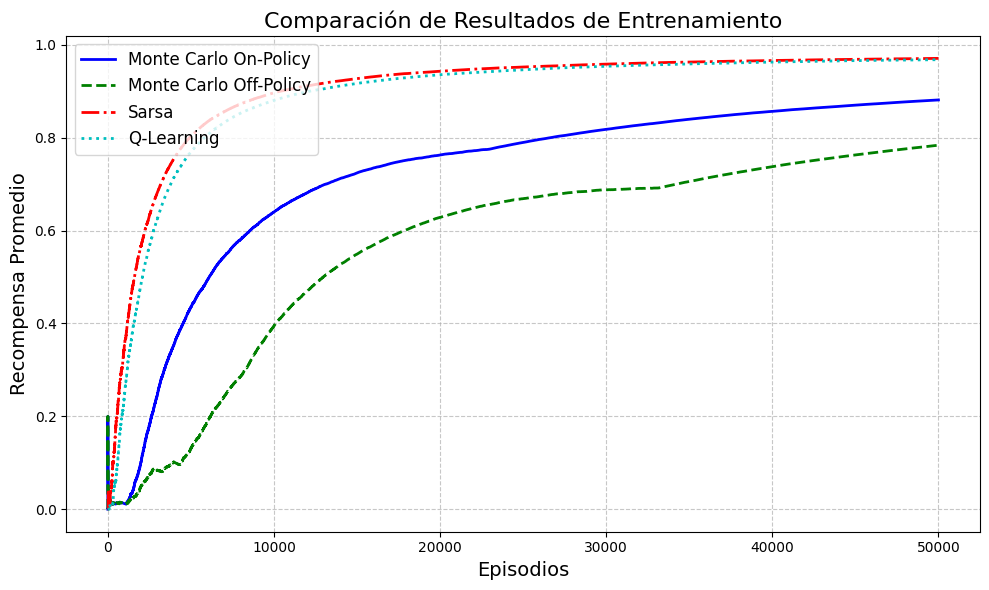

In [31]:
plot_comparison(stats_list=[stats_mc_on_policy,stats_mc_off_policy4x4,stats_sarsa,stats_ql], labels=["Monte Carlo On-Policy", "Monte Carlo Off-Policy", "Sarsa","Q-Learning"])

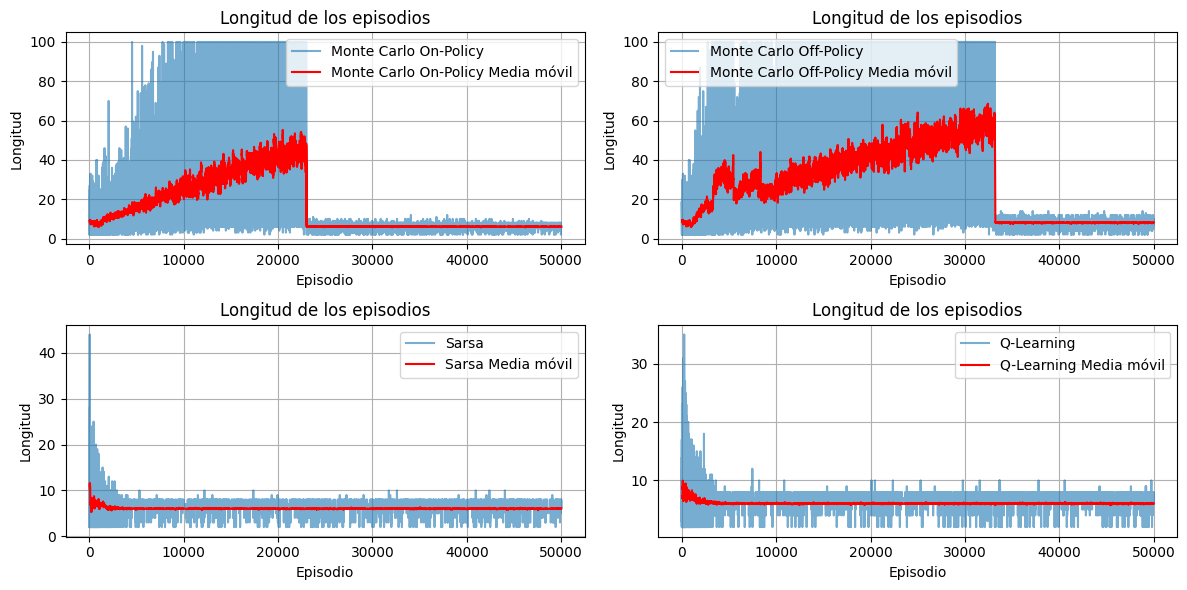

In [32]:
plot_multiple_episode_lengths(
    [episode_lengths_mc_on_policy, episode_lengths_mc_off_policy4x4,
     episode_lengths_sarsa, episode_lengths_ql],
    labels=["Monte Carlo On-Policy", "Monte Carlo Off-Policy", "Sarsa", "Q-Learning"])

Al analizar las recompensas promedio, se aprecia que todos los algoritmos logran mejorar su desempeño a lo largo del entrenamiento, aunque difieren en la rapidez con la que convergen. **Monte Carlo On-Policy** y **Monte Carlo Off-Policy** muestran un crecimiento más lento y una mayor variabilidad en las etapas iniciales, lo que indica que requieren más episodios para consolidar una política estable. Por el contrario, **Sarsa** y **Q-Learning** incrementan sus recompensas de forma más acelerada, evidenciando una capacidad de aprendizaje más estable desde los primeros miles de episodios.

En cuanto a la **longitud de los episodios**, se observa que **Sarsa** logra una reducción notablemente rápida y se mantiene en valores bajos de manera sostenida, lo que sugiere que el agente encuentra rutas eficientes hacia la meta y permanece en ellas de forma confiable. **Q-Learning**, por su parte, también alcanza episodios cortos, pero experimenta picos ocasionales que pueden prolongar algunos recorridos, reflejando cierta inestabilidad en su política en momentos puntuales.

Si bien todos los algoritmos terminan resolviendo el entorno y alcanzando recompensas cercanas a 1, **Sarsa** destaca por su **consistencia** y **estabilidad**. Al mantener episodios breves y recompensas altas de manera más uniforme, el agente demuestra un aprendizaje sólido y menos propenso a altibajos. **Q-Learning** es muy competitivo y también alcanza un rendimiento sobresaliente, pero sus fluctuaciones indican que, en ocasiones, tarda un poco más en recuperar una política óptima cuando se aleja de ella.

En conjunto, tanto **Sarsa** como **Q-Learning** son excelentes opciones para este entorno, ofreciendo un aprendizaje rápido y resultados satisfactorios. Sin embargo, el comportamiento más regular de Sarsa le otorga una **ligera ventaja** en términos de estabilidad, posicionándolo como el mejor algoritmo en este experimento.